<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/langchain/langgraph/LangGraph_agent_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangGraph
LangGraph is a stateful, orchestration framework that brings added control to agent workflows. LangGraph Platform is a service for deploying and scaling LangGraph applications, with an opinionated API for building agent UXs, plus an integrated developer studio.

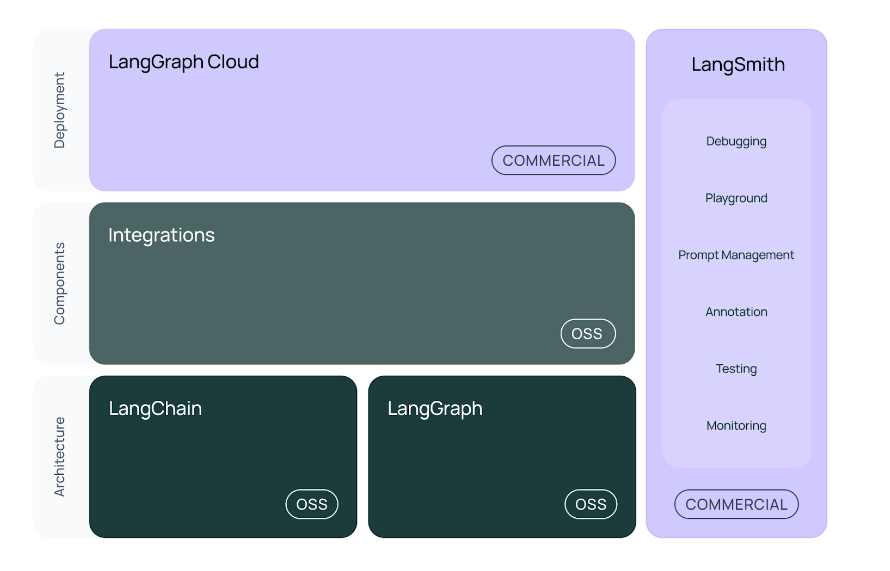




# Langchain vs LangGrah



LangChain:

LangChain utilizes a code-based workflow structure, meaning workflows are written and managed through Python code. This approach is straightforward for developers comfortable with coding, allowing them to define the flow through scripts without needing any additional tools. LangChain’s modular design lets users link different tasks through custom scripts and functions, which can lead to flexibility but may require more complex code for intricate workflows.

LangGraph:

LangGraph, on the other hand, is structured around a graph-based or declarative model that emphasizes visual representation. Users can create and manage workflows through a graphical interface, making it more accessible for users who may not have extensive coding experience. This visual approach aids in understanding complex dependencies, making it easier to track and manage task interactions within a complex workflow.

https://blog.blockmagnates.com/langchain-vs-langgraph-a-comprehensive-comparison-of-language-model-frameworks-ec8a88785c6d



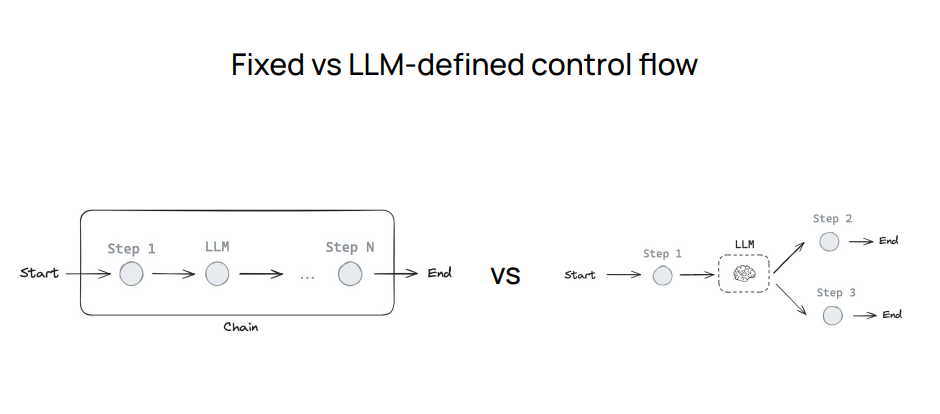

# Agent
An agent is a system that uses an LLM to decide the control flow of an application. There are many ways that an LLM can control application:

- An LLM can route between two potential paths
- An LLM can decide which of many tools to call
- An LLM can decide whether the generated answer is sufficient or more work is needed

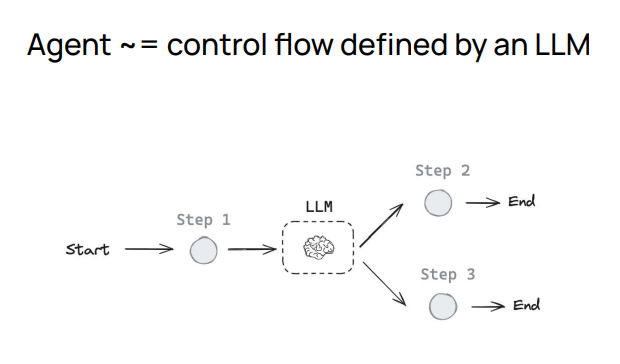


# Router
A router allows an LLM to select a single step from a specified set of options. This is an agent architecture that exhibits a relatively limited level of control because the LLM usually governs a single decision and can return a narrow set of outputs

# Structured Output
Structured outputs with LLMs work by providing a specific format or schema that the LLM should follow in its response. This is similar to tool calling, but more general. While tool calling typically involves selecting and using predefined functions, structured outputs can be used for any type of formatted response. Common methods to achieve structured outputs include:

- Prompt engineering: Instructing the LLM to respond in a specific format.
- Output parsers: Using post-processing to extract structured data from LLM responses.
- Tool calling: Leveraging built-in tool calling capabilities of some LLMs to generate structured outputs.

# Memory
Memory is crucial for agents, enabling them to retain and utilize information across multiple steps of problem-solving. It operates on different scales:

- Short-term memory: Allows the agent to access information acquired during earlier steps in a sequence.
- Long-term memory: Enables the agent to recall information from previous interactions, such as past messages in a conversation.

# React Agent


https://react-lm.github.io/
ReAct: Synergizing Reasoning and Acting in Language Models
https://arxiv.org/pdf/2210.03629


* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

# Planning
In the ReAct architecture, an LLM is called repeatedly in a while-loop. At each step the agent decides which tools to call, and what the inputs to those tools should be. Those tools are then executed, and the outputs are fed back into the LLM as observations. The while-loop terminates when the agent decides it is not worth calling any more tools.

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [ ]:
import os, getpass
from google.colab import userdata

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = userdata.get(f"{var}")

_set_env("OPENAI_API_KEY")

[LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).



https://docs.smith.langchain.com/observability/concepts

In [ ]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph-react-agent"

In [ ]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

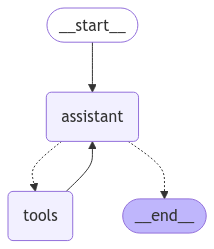

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

Memory is crucial for agents, enabling them to retain and utilize information across multiple steps of problem-solving. It operates on different scales:

- Short-term memory: Allows the agent to access information acquired during earlier steps in a sequence.
- Long-term memory: Enables the agent to recall information from previous interactions, such as past messages in a conversation.

In [ ]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_Y8NoIH0esrJhZmjXkF5RlJFF)
 Call ID: call_Y8NoIH0esrJhZmjXkF5RlJFF
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


Now, let's multiply by 2!

In [ ]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

Could you please provide the number you would like to multiply by 2?


We don't retain memory of 7 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions.

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this!

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [ ]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_QrxREzosfLRgK96M8HJN5qom)
 Call ID: call_QrxREzosfLRgK96M8HJN5qom
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.


If we pass the same `thread_id`, then we can proceed from from the previously logged state checkpoint!

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [ ]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_QrxREzosfLRgK96M8HJN5qom)
 Call ID: call_QrxREzosfLRgK96M8HJN5qom
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_iQfjbK41dVYIi0bn2QbOC6Sy)
 Call ID: call_iQfjbK41dVYIi0bn2QbOC6Sy
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result 